In [1]:
import os
import mne
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Path to the directory containing .fif files
fif_dir = os.path.join('..', 'eeg_data', 'final_eeg', '05_125')

# List all .fif files in the directory
fif_files = [f for f in os.listdir(fif_dir) if f.endswith('.fif')]

# Initialize an empty list to hold epochs from all files
all_epochs = []

for fif_file in fif_files:
    processed_fif_path = os.path.join(fif_dir, fif_file)
    epochs = mne.read_epochs(processed_fif_path, preload=True)
    all_epochs.append(epochs)

# Concatenate epochs from all files
concatenated_epochs = mne.concatenate_epochs(all_epochs)

Reading /Users/charles/Developer/all-joined/alljoined_preprocessing/snr/../eeg_data/final_eeg/05_125/subj04_session1_epo.fif ...
    Found the data of interest:
        t =     -50.78 ...     599.61 ms
        0 CTF compensation matrices available
Not setting metadata
3752 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/charles/Developer/all-joined/alljoined_preprocessing/snr/../eeg_data/final_eeg/05_125/subj01_session2_epo.fif ...
    Found the data of interest:
        t =     -50.78 ...     599.61 ms
        0 CTF compensation matrices available
Not setting metadata
3072 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/charles/Developer/all-joined/alljoined_preprocessing/snr/../eeg_data/final_eeg/05_125/subj04_session2_epo.fif ...
    Found the data of interest:
        t =     -50.78 ...     599.61 ms
        0 CTF compensation matrices available
Not setting metadata
3073 matching event

Event ID: 1, N: 38, SNR: [2.45339761e-01 9.40546977e-01 3.45109168e+00 3.20419133e+00
 3.57562197e+00 4.34050195e+00 3.46380965e+00 3.27384696e+00
 2.42049310e+00 3.49865778e+00 2.18205885e+00 2.81037542e+00
 4.11703697e+00 3.68541719e+00 2.86532861e+00 8.84104589e-01
 1.93350926e+00 1.63086985e+00 7.47581330e-01 2.84502820e+00
 3.04596097e+00 2.10606506e+00 8.07923582e-01 1.37013776e+00
 3.69045098e+00 4.94713232e+00 4.82670496e+00 3.39980594e+00
 3.90809654e+00 4.71225043e+00 3.32480683e+00 2.03769571e-01
 2.24650413e+00 1.45066851e+00 3.02366519e-01 3.12730021e+00
 3.87155658e+00 3.38611382e+00 3.55253498e+00 1.38794030e+00
 2.47026863e+00 2.41179979e+00 9.53187121e-01 2.02582027e+00
 3.11709138e+00 2.92287915e+00 3.38658357e+00 2.30331610e+00
 1.59077744e+00 2.03409621e+00 4.07425332e-01 3.17491822e-03
 1.31094723e+00 2.28470987e+00 2.27686674e+00 6.29040779e-01
 4.78147834e+00 7.20028904e+00 4.81170674e+00 3.13984006e+00
 2.18151273e+00 5.62253415e+00 4.80450817e+00 5.84490885e+00

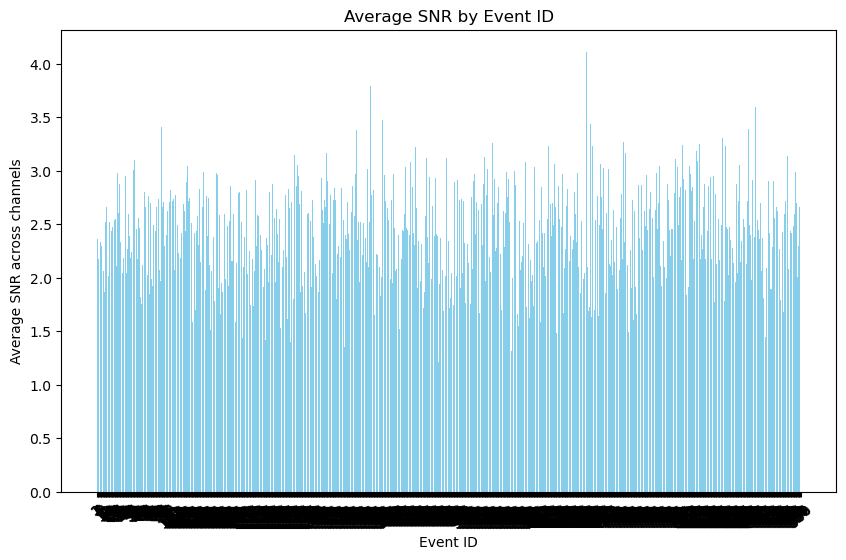

In [3]:
# Define the time window in seconds
tmin, tmax = 0.1, 0.3

# We will calculate SNR for each unique event in the concatenated epochs
event_ids = concatenated_epochs.event_id
snr_results = {}

for event_id, _ in event_ids.items():
    # Select epochs for the current event_id
    epochs_specific = concatenated_epochs[event_id]
    
    # Get data and times, restrict to the time window of interest
    data = epochs_specific.get_data(picks='eeg')  # shape: (n_epochs, n_channels, n_times)
    times = epochs_specific.times
    time_window_mask = (times >= tmin) & (times <= tmax)
    
    # Calculate mean amplitude in the specified time window for each epoch
    mean_amplitudes = data[:, :, time_window_mask].mean(axis=2)
    
    # Calculate the average ERP waveform (signal) across epochs for the event_id
    signal = mean_amplitudes.mean(axis=0)
    
    # Calculate the standard deviation across epochs for each channel
    sd = np.std(mean_amplitudes, axis=0)
    
    # Calculate N (the number of epochs for the current event_id)
    N = len(epochs_specific)
    
    # Calculate the Simple Measurement Error (SME) for each channel
    SME = sd / np.sqrt(N)
    
    # Calculate SNR for each channel
    SNR = np.abs(signal) / SME
    
    # Store the results
    snr_results[event_id] = SNR


    print(f"Event ID: {event_id}, N: {N}, SNR: {SNR}, SME: {SME}")

# Optionally, print the SME for each event_id (and each channel, if you wish)
# for event_id, SME in sme_results.items():
#     print(f"Event ID: {event_id}")
#     for i, sme_value in enumerate(SME):
#         print(f"  Channel {i+1}: SME = {sme_value}")

# Plotting SNR for a representative channel or average over channels, if preferred
# For simplicity, let's plot the average SNR across channels for each event ID
average_snr_per_event = {event_id: np.mean(SNR) for event_id, SNR in snr_results.items()}
events = list(average_snr_per_event.keys())
average_snr_values = list(average_snr_per_event.values())

plt.figure(figsize=(10, 6))
plt.bar(events, average_snr_values, color='skyblue')
plt.xlabel('Event ID')
plt.ylabel('Average SNR across channels')
plt.title('Average SNR by Event ID')
plt.xticks(rotation=45)
plt.show()
